# Deep Forecasting: Predicting Cryptocurrency Prices with CNN, LSTM, and Transfer Learning

### Introduction
In this notebook we will collect price history data for the top 100 coins by marketcap. We will chunk data into 2D tensors of 90x5 where 90 is number of days of input, and 5 is  the number of feature points per coin per day. Feature points are: ['Open', 'High', 'Low', 'Close', 'DayOfYear']. From this time series data, our model will learn to predict how prices will change for 1, and 30, days in the future. Our experiments include both an LSTM and a CNN implementation, both of which take the same data as input. 

Original models will be trained for Binary Prediction, that is, to predict if a price will go up or down after n days. We will use transfer learning by retraining the final layers of the model for alternative forecast types. We will implement three forecast types Binary, Linear, and Stochastic; the only difference bieng their respective output activation functions: Sigmoid, Linear, and Softmax.

### 1. Data Collection and Aquisition
* Coinmarketcap module
* Coin anonymity
* Input Shape: (90,5)

### 2. Model Definitions
* CNN
* LSTM

### 3. Binary Forecasting
* Binary Forecasting
    * For each coin, predict if the price of that coin will be higher or lower in n days.
    * Activation: sigmoid
    * Target: sigmoid(future price / current price)

### 4. Linear Forecasting with Transfer Learning
* Linear Forecasting or Price Prediction:
    * Predict the actual price of a coin at a future date.
    * Additional Layer: Dense(21)
    * Activation: linear
    * Target: future price / current price

### 5. Applications
* Cryptocurrency Investment Recommendations
    * A ranking of coin evaluations and predicted prices
    
### 6. Future Work
* Stochastic Forecasting: 
    * Produce a stochastic evaluation over all coins. That is, produce a vector of length equal to number of coins, whos elements are non-zero and sum to one. Each element of the vector is a scalar evaluation of a coin. This vector can be thought of as a confidence distribution over the coins, where the higher the evaluation, the higher the confidence of gain in price. This vector can also be used to simulate an investment portfolio, as a portfolio can be seen as a stochastiv vector of assets.
    * This requires an additional dimension input. Inputs must be stacked in a Tensor
    * Activation: softmax
    * Target: softmax(future prices / current prices)
    
* Application: Portfolio Recommendation
    * A recommended portfolio distribution for cryptocurrency investment

### 7. Conclusion


## 0. Dependencies and Experiment Parameters

In [93]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import tqdm

DAYS_BLK  = 90 # Number of input days for learning
TARGETS   = [1, 10, 30, 90] # Number of days to predict in the future
TEST_DAYS = 30 # Number of most recent days to withold from the training set for testing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Data Acquisition and Cleaning

In [94]:
def compile_samples(coins, DAYS_BLK, TARGETS, TEST_DAYS):
    # Compile a list of training examples, accompanied by target values for future prices
    train_samples = []
    for coin in tqdm.tqdm(coins):
        # Get all available price history for a given coin
        coin_data = coin.read_history()

        # Drop unneccessary columns
        coin_data = coin_data.drop(['Volume', 'Market Cap', 'Unnamed: 0'], 1) 

        # Reverse date ordering so we predict the future instead of the past
        coin_data['Date'] = pd.to_datetime(coin_data['Date'])
        coin_data = coin_data.sort_values(['Date']) 

        # Convert Date to Day of Year(DOY)
        coin_data['DOY'] = coin_data['Date'].apply(lambda x: x.dayofyear)
        coin_data = coin_data.drop(['Date'], 1)

        # Chunk coin history into input/target train pairs
        for t in range(len(coin_data) - DAYS_BLK - TARGETS[-1] - TEST_DAYS):

            # X is a 90 day chunk of shape: (90, 5)
            X = coin_data.iloc[t:t+DAYS_BLK].copy()
            # y is a list of future prices [1, 10, 30, 90] days after X
            y = [coin_data.iloc[t+DAYS_BLK+n]['Close'] for n in TARGETS]

            # Normalize prices relative to the final input close price
            price_cols = ['Open', 'High', 'Low', 'Close']
            current_price = X.values[-1][3]
            for col in price_cols:
                X[col] = X[col] / current_price

            # Normalize future prices by current price
            y = [future_price / current_price for future_price in y]

            # Normalize DOY column
            X['DOY'] = X['DOY'] / 365

            # Sample is ready
            train_samples.append((X.values, y))
    return train_samples

In [95]:
# Get a list of coin objects for the top 100 coins from coinmarketcap.com
from Scrapers.Coinmarketcap.coinmarketcap import CoinMarketcap
cmk = CoinMarketcap()
coins = cmk.coins()

In [96]:
# Cache samples because compiling them is timely
RECOMPILE_SAMPLES = False
if RECOMPILE_SAMPLES:
    samples = compile_samples(coins, DAYS_BLK, TARGETS, TEST_DAYS)
    pickle.dump(samples, open( "dataset.pickle", "wb" ) )
else:
    try:
        print("Checking Cache...")
        samples = pickle.load(open('dataset.pickle','rb'))
        print("Cached samples loaded!")
    except FileNotFoundError:
        print("Cached samples not found. Fetching data and compiling samples...")
        samples = compile_samples(coins, DAYS_BLK, TARGETS)
        print("Caching samples...")
        pickle.dump(samples, open( "dataset.pickle", "wb" ) )
        print("Done!")

Checking Cache...
Cached samples loaded!


In [97]:
# Split samples into inputs and targets
X,y = zip(*samples)
assert(len(X) == len(y))
len(X)

34926

## 2. Model Definitions

In [98]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, LSTM, Dropout

# Assert input shape
N = 90 # Number of Days
F = 5  # Number of Features: ['Open', 'High', 'Low', 'Close', 'DayOfYear']
assert((N, F) == samples[0][0].shape)

binary_kwargs = {
    'output':'sigmoid',
    'metrics':['accuracy'],
    'loss':'binary_crossentropy',
}
linear_kwargs = {
    'output':'linear',
    'metrics':['mae', 'mse'],
    'loss':'mean_squared_error',
}

In [99]:
def build_CNN(output='sigmoid', activations='selu', metrics=['accuracy'], loss='binary_crossentropy', optimizer='adam'):
    # Define our Temporal Convolutional Model
    model = Sequential()
    model.add(Conv1D(filters=4, kernel_size=3, activation=activations, input_shape=[N,F]))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=4, kernel_size=3, activation=activations))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=16, kernel_size=21, activation=activations))
    model.add(Flatten())
    model.add(Dense(1, activation=output)) # 'linear' for price prediction, 'softmax' for stochastic forecasting
    
    # Compile our Model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model

In [100]:
def build_LSTM(output='sigmoid', activations='selu', metrics=['accuracy'], loss='binary_crossentropy', dropout=0.25, optimizer="adam"):
    model = Sequential()
    model.add(LSTM(4, input_shape=(N,F)))
    model.add(Dropout(dropout))
    model.add(Dense(units=1, activation=output))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

## 3. Binary Forecasting

In [101]:
# How many days into the future would you like to predict? Options: [1,10,30,90]
n_days = 1
target_index = TARGETS.index(n_days)

# target[0] is the price 1 day after input
y = [target[0] for target in y]

# convert target to boolean. 0 means price went down, 1 means price went up
y = [int(target>1) for target in y]

In [107]:
CNN_model = build_CNN(**binary_kwargs)
CNN_history = CNN_model.fit(np.array(X), np.array(y), epochs=5, batch_size=32, validation_split=0.2)

Train on 27940 samples, validate on 6986 samples
Epoch 1/5
27940/27940 [==============================] - 3s 112us/step - loss: 0.6900 - acc: 0.5390 - val_loss: 0.6935 - val_acc: 0.5321
Epoch 2/5
27940/27940 [==============================] - 3s 101us/step - loss: 0.6871 - acc: 0.5483 - val_loss: 0.6903 - val_acc: 0.5412
Epoch 3/5
27940/27940 [==============================] - 3s 99us/step - loss: 0.6851 - acc: 0.5566 - val_loss: 0.6897 - val_acc: 0.5401
Epoch 4/5
27940/27940 [==============================] - 3s 99us/step - loss: 0.6835 - acc: 0.5603 - val_loss: 0.6942 - val_acc: 0.5268
Epoch 5/5
27940/27940 [==============================] - 3s 99us/step - loss: 0.6832 - acc: 0.5601 - val_loss: 0.6893 - val_acc: 0.5508


In [108]:
LSTM_model = build_LSTM(**binary_kwargs)
LSTM_history = LSTM_model.fit(np.array(X), np.array(y), epochs=2, batch_size=32, validation_split=0.2)

Train on 27940 samples, validate on 6986 samples
Epoch 1/2
27940/27940 [==============================] - 28s 985us/step - loss: 0.6922 - acc: 0.5244 - val_loss: 0.6911 - val_acc: 0.5256
Epoch 2/2
27940/27940 [==============================] - 30s 1ms/step - loss: 0.6893 - acc: 0.5360 - val_loss: 0.6914 - val_acc: 0.5268


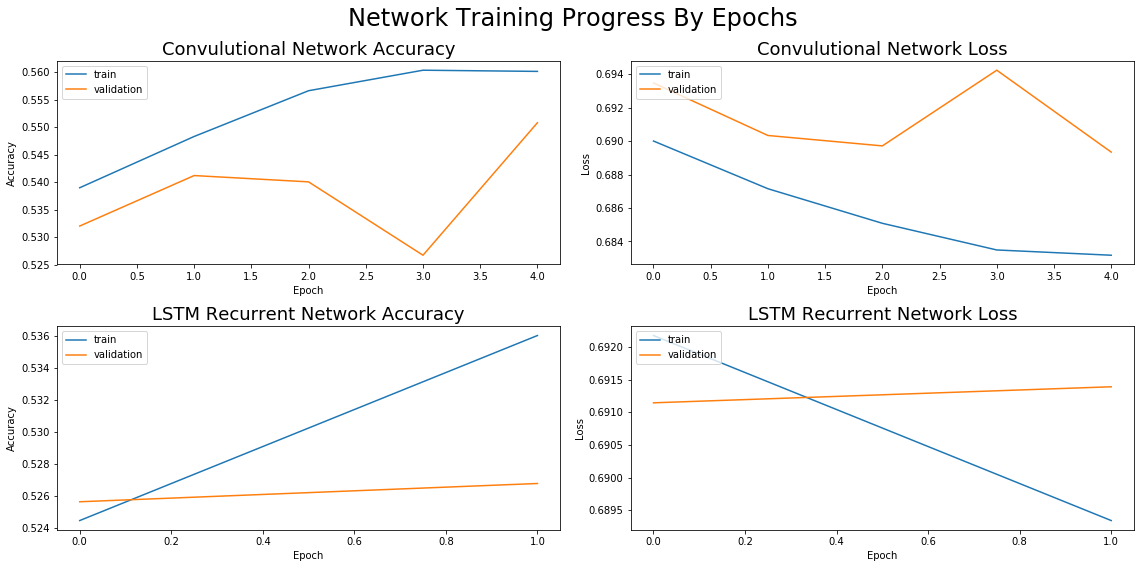

In [109]:
plt.figure(figsize=(16,8))
plt.suptitle("Network Training Progress By Epochs", fontsize=24)

model_titles = ['Convulutional Network', 'LSTM Recurrent Network']
metric_titles = {'acc':'Accuracy', 'loss':'Loss'}
for col, metric in enumerate(['acc', 'loss']):
    for row, history in enumerate([CNN_history, LSTM_history]):
            ax = plt.subplot(2,2,(row)*2 + (col+1))
            plt.plot(history.history[metric])
            plt.plot(history.history['val_' + metric])
            plt.title(model_titles[row] + " " + metric_titles[metric], fontsize=18)
            plt.ylabel(metric_titles[metric])
            plt.xlabel('Epoch')
            plt.legend(['train', 'validation'], loc='upper left')
# Fix subplot and title allignment
plt.tight_layout(rect=[0, 0, 1, 0.94])

## 4. Linear Forecasting with Transfer Learning

## 5. Applications

### Cryptocurrency Investment Recommendations